<a href="https://colab.research.google.com/github/mnsv73/brain-tumour-segmentation/blob/master/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#imports 
import numpy as np
import pandas as pd
import matplotlib as mlt
import tensorflow as tf
import os
import pathlib
import keras
from keras import regularizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Input
from keras.layers import Activation, ZeroPadding2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import h5py
from keras.utils import layer_utils

Using TensorFlow backend.


In [0]:
!pip3 install medpy

     |████████████████████████████████| 153kB 4.4MB/s 
     |████████████████████████████████| 42.5MB 97kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753465 sha256=14eed250f85885ce41597bc9949343454c14a8a7292307734bd30aba1b1d864f
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


In [0]:
#code for linking google drive and google colab.. 1. run this script 2. enter the authorization code and press enter 3. drive will be mounted sucessfully
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

#now coming to pre-processing
#stuff to do.... the 1% highest and lowest intensities are removed. lite
#Then, we apply an N4ITK bias correction to T1 and T1C modalities. when to do?
#The data is then normalized
#write the code to load all the images...
#trial... and final input
#inputs of function.. path1, path2, path3 and path4 are paths of image modalities flair, t1, t1c and t2 respectively
# a is the index of the 2D image depthwise.. in our case it seems to range from 0 to 155
#output is a tensor which can be fed into CNN...
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from medpy.io import load, save
def gen_image(path1, path2, path3,path4, a):   
  image_t1, image_header1 = load(path2)
  image_t2, image_header2 =load(path4)
  image_t1c, image_header1c =load(path3)
  image_flair, image_headerr =load(path1)
  t1x, t1y, t1z = image_t1.shape
  #assumption.. all channels are equi-dimensional
  
  imgt1 = image_t1[:,:,a]
  imgt1 = normalize(imgt1)
  imgt2 = image_t2[:,:,a]
  imgt2 = normalize(imgt2)
  imgt1c = image_t1c[:,:,a]
  imgt1c = normalize(imgt1c)
  imgtflair = image_flair[:,:,a]
  imgtflair = normalize(imgtflair)
  #images are stacked depth wise
  final_image = np.dstack([imgt1, imgt2, imgt1c, imgtflair])

  #print(final_image.shape)
  #plt.imshow(imgt1,cmap = cm.Greys_r)
  #plt.show()
  #plt.imshow(imgt2,cmap = cm.Greys_r)
  #plt.show()
  #plt.imshow(imgt1c,cmap = cm.Greys_r)
  #plt.show()
  #plt.imshow(imgtflair,cmap = cm.Greys_r)
  #plt.show()
  #final image cant be visulaised properly, imshow supports only RGB channels
  #plt.imshow(final_image)
  #plt.show()
  

  #final_tensor = to_tensor(final_image)
  return final_image


In [0]:
#n dimensional numpy array to tensor
import torch
def to_tensor(arr):
  tens = torch.from_numpy(arr)
  return tens


In [0]:
#N4 Normalisation to be done for T1 and T1c .mha files

import SimpleITK as sitk

path='/content/gdrive/My Drive/NNFL Assignment/BRATS 2015 Dataset/Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_T1.54513/VSD.Brain.XX.O.MR_T1.54513.mha'
#path is the location of the .mha file. Modify it as per the files in your drive. 

inputImage = sitk.ReadImage(path)
maskImage = sitk.OtsuThreshold( inputImage, 0, 1, 200 )
#Otsu thresholding sets the default mask

inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
#Actual input image is of type int16, it has to be cast to Float32 
corrector = sitk.N4BiasFieldCorrectionImageFilter()
#corrector.SetMaximumNumberOfIterations( 1 ). It takes the default value for number of iterations.

output = corrector.Execute( inputImage, maskImage )

output_fn = path[:-4] + '_n.mha'
#Output normalised image is stored in the same folder as input with the input filename along with _n.mha
sitk.WriteImage( output, output_fn)


In [0]:
#For comparing the images before and after N4 normalisation
image_data1, image_header1 = load('/content/gdrive/My Drive/BRATS2015_Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_T1c.54514/VSD.Brain.XX.O.MR_T1c.54514.mha')
#This is the original image
image_data2, image_header2 = load('/content/gdrive/My Drive/BRATS2015_Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_T1c.54514/VSD.Brain.XX.O.MR_T1c.54514_n.mha')
#The same image after normalisation
for a in [5,25,46,57,68,74,90,100]:
  image1 = image_data1[:,:,a]
  image2 = image_data2[:,:,a]
  
  plt.imshow(image1,cmap='gray')
  plt.show()
  
  plt.imshow(image2,cmap='gray')
  plt.show()

In [0]:
#to check only one brain here
#path = '/content/gdrive/My Drive/NNFL Assignment/brats_tcia_pat493_0001'
path = '/content/gdrive/My Drive/BRATS2015_Training/HGG/brats_tcia_pat499_0001'
output = []
#hf = h5py.File('/content/gdrive/My Drive/NNFL Assignment/data1.h5', 'a')
hf = h5py.File('/content/gdrive/My Drive/NNFL Assignment/data_may1.h5', 'a')
j=0
with os.scandir(path) as brats:
  modularity_path = []
  for folder3 in brats:          
    path3 = path + '/' + folder3.name
    if (folder3.name.find('more')!=-1):
      with os.scandir(path3) as vsdbrain:
        for file in vsdbrain:
          if file.name.endswith('mha'):
            path4 = path3 + '/' + file.name
            output.append(path4)
    else:
      with os.scandir(path3) as vsdbrain:
        for file in vsdbrain:
          if file.name.endswith('mha'):
            path4 = path3 + '/' + file.name
            modularity_path.append(path4)      
#pass the modularity path values to gen_image, but what to return and how to manage
sorted_path = sorted(modularity_path)
print(sorted_path)
g = hf.create_group(str(j))
for i in range (0, 155):
  #can use tables. directly send it for training
  d = gen_image(sorted_path[0], sorted_path[1], sorted_path[2], sorted_path[3], i )
  g.create_dataset(str(i), data=d)
j=j+1
print(j)
print(output)

['/content/gdrive/My Drive/BRATS2015_Training/HGG/brats_tcia_pat499_0001/VSD.Brain.XX.O.MR_Flair.36620/VSD.Brain.XX.O.MR_Flair.36620.mha', '/content/gdrive/My Drive/BRATS2015_Training/HGG/brats_tcia_pat499_0001/VSD.Brain.XX.O.MR_T1.36621/VSD.Brain.XX.O.MR_T1.36621.mha', '/content/gdrive/My Drive/BRATS2015_Training/HGG/brats_tcia_pat499_0001/VSD.Brain.XX.O.MR_T1c.36622/VSD.Brain.XX.O.MR_T1c.36622.mha', '/content/gdrive/My Drive/BRATS2015_Training/HGG/brats_tcia_pat499_0001/VSD.Brain.XX.O.MR_T2.36623/VSD.Brain.XX.O.MR_T2.36623.mha']
1
['/content/gdrive/My Drive/BRATS2015_Training/HGG/brats_tcia_pat499_0001/VSD.Brain_3more.XX.O.OT.42835/VSD.Brain_3more.XX.O.OT.42835.mha']


In [0]:
#to convert ground truth(output) to arrays, store it in a different FILE.... 240,240,155
for i in range(len(output)):
  data, header = load(output[i])



<HDF5 group "/0" (155 members)>
<HDF5 dataset "57": shape (240, 240, 4), type "<f8">


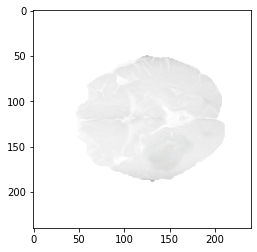

In [0]:
g1 = hf.get('0')
print(g1)
d1 = g1.get('57')
print(d1)
n1 = np.array(d1)
plt.imshow(n1)
plt.show()
#print(n1)

In [0]:
hf.close()

In [0]:
#loading and pre-processing of training set
#no of folders in: LGG 54     HGG 220
#273MB per brain, 73GB?
#path = '/content/gdrive/My Drive/NNFL Assignment/BRATS 2015 Dataset/Training/'
path = '/content/gdrive/My Drive/BRATS2015_Training/'
output = []
df = h5py.File('/content/gdrive/My Drive/NNFL Assignment/data_may1final2.h5', 'a')
j=0
with os.scandir(path) as training:
  for folder1 in training:
    path1 = path + '/' + folder1.name
    with os.scandir(path1) as lgg_hgg:
      for folder2 in lgg_hgg:
        path2 = path1 + '/' + folder2.name
        #print(folder2.name)
        with os.scandir(path2) as brats:
          modularity_path = []
          for folder3 in brats:          
            path3 = path2 + '/' + folder3.name
            if (folder3.name.find('more')!=-1):
              with os.scandir(path3) as vsdbrain:
                for file in vsdbrain:
                  if file.name.endswith('mha'):
                    path4 = path3 + '/' + file.name
                    output.append(path4)
            else:
              with os.scandir(path3) as vsdbrain:
                for file in vsdbrain:
                  if file.name.endswith('mha'):
                    path4 = path3 + '/' + file.name
                    modularity_path.append(path4)      
        #pass the modularity path values to gen_image, but what to return and how to manage
        sorted_path = sorted(modularity_path)
        #print(sorted_path)
        g = df.create_group(str(j))
        for i in range (0, 155):
          d = gen_image(sorted_path[0], sorted_path[1], sorted_path[2], sorted_path[3], i )
          g.create_dataset(str(i), data=d)
        j=j+1
        print(j)
#print(output)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [0]:
#no need to run if you have just created file
df = h5py.File('/content/gdrive/My Drive/NNFL Assignment/data_final.h5', 'r')

In [0]:
for key in df.keys():
  print(key)

0


In [0]:
g1 = df.get('27')
print(g1)
d1 = g1.get('43')
print(d1)
n1 = np.array(d1)
plt.imshow(n1)
plt.show()
#print(n1)'''

None


"d1 = g1.get('43')\nprint(d1)\nn1 = np.array(d1)\nplt.imshow(n1)\nplt.show()\n#print(n1)"

In [0]:


#two way model code... img is a tensor
def two_way_CNN(img):
  
  #valid padding means no padding, stride is 1 by default
  
  O1 = Conv2D(filters= 64,kernel_size =(7,7),strides=(1,1),padding='valid',kernel_regularizer=regularizers.l1_l2(0.01,0.01))(img)
  O2 = Conv2D(filters= 64,kernel_size =(7,7),strides=(1,1),padding='valid',kernel_regularizer=regularizers.l1_l2(0.01,0.01))(img)
  #Maxout function... as per my understanding
  #It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
  Max_O = keras.layers.Maximum()([O1,O2])
  Max_O = MaxPooling2D(pool_size=(4,4), padding='valid',strides=(1,1), data_format='channels_last')(Max_O)
  
   #Coming to the second layer ...
  O3 = Conv2D(filters= 64,kernel_size =(3,3),strides=(1,1),padding='valid',kernel_regularizer=regularizers.l1_l2(0.01,0.01))(Max_O)
  O4 = Conv2D(filters= 64,kernel_size =(3,3),strides=(1,1),padding='valid',kernel_regularizer=regularizers.l1_l2(0.01,0.01))(Max_O)
  Max_O = keras.layers.Maximum()([O3,O4])
  Max_O = MaxPooling2D(pool_size=(2,2),padding='valid',strides=(1,1),data_format='channels_last')(Max_O)

   #for the second path(global).. no pooling here
  O5=Conv2D(filters= 160,kernel_size =(13,13),strides=(1,1),padding='valid',kernel_regularizer=regularizers.l1_l2(0.01,0.01))(img)
  O6=Conv2D(filters= 160,kernel_size =(13,13),strides=(1,1),padding='valid',kernel_regularizer=regularizers.l1_l2(0.01,0.01))(img)
  Max_O3 = keras.layers.Maximum()([O5,O6])

 

 

  #time for concatenation...
  Max_O4 = Concatenate()([Max_O,Max_O3])
  #our final output...
  Max_O5 = Conv2D(filters=5,kernel_size=(21,21),strides=(1,1), padding ='valid', activation = 'softmax',kernel_regularizer=regularizers.l1_l2(0.01,0.01))(Max_O4)
  return Max_O5

In [0]:
#Input cascade function....both inputs are Keras Tensors
def inputCascadeCNN():
  #size of patch in img1 is 4x65x65 and is fed to two way CNN
  #size of patch in img2 is 4x33x33 and is fed directly to this one
  img1 = Input((65,65,4))
  
  O1 = two_way_CNN(img1)   
  # we got the output time for concatenation
  
  img2 = Input((33,33,4))    #9*33*33
  O2 = Concatenate()([O1,img2])
  # Concatenated input is fed into two way again...
  
  O2 = two_way_CNN(O2)
  final_model = Model(inputs = [img1, img2], outputs = O2 )
  return final_model

In [0]:
model = inputCascadeCNN()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65, 65, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
maximum_1 (Maximum)             (None, 59, 59, 64)   0           conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]             

In [0]:
#for training the data...
#Configures the model for training.. go to https://keras.io/models/model/ for more info
model.compile(loss='mean_squared_error', metrics = ['accuracy'])
#insert the input given by x and the output given by y as the parameters...
#x should be a list of one same image repeated twice
model.fit(x=,y=,batch_size=128)
#for predicting..
#insert the input as x
model.predict(x=,batch_size=128)


SyntaxError: ignored

In [0]:
data = np.array([x for x in range(0,1000)])
for i in range(0, 1000):
   model.fit([np.array([data[i]]), np.array([data[i]]), nb_epochs=1, batch_size=1, verbose=0)

SyntaxError: ignored

In [0]:
data, header = load(output[0])
for i in range(0, 155):
  img = data[:,:,i]
  plt.imshow(img, cmap=None)
  plt.show()

IndexError: ignored